# 积分图像计算

积分图像是Crow在1984年首次提出，是为了在多尺度透视投影中提高渲染速度。随后这种技术被应用到基于NCC的快速匹配、对象检测和SURF变换中、基于统计学的快速滤波器等方面。积分图像是一种在图像中快速计算矩形区域和的方法，这种算法主要优点是一旦积分图像首先被计算出来我们可以计算图像中任意大小矩形区域的和而且是在常量时间内。这样在图像模糊、边缘提取、对象检测的时候极大降低计算量、提高计算速度。第一个应用积分图像技术的应用是在Viola-Jones的对象检测框架中出现。

在积分图像(Integral Image - ii)上任意位置(x, y)处的ii(x, y)表示该点左上角所有像素之和，表示如下：
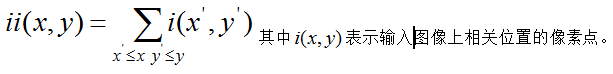

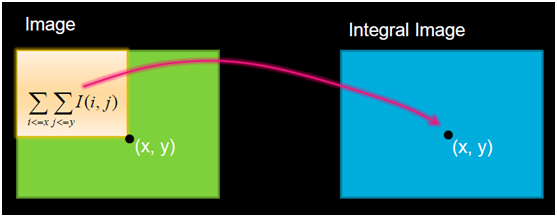
从给定图像I从上到下、从左到右计算得到和的积分图像公式如下：

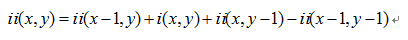
其中(x<0 || y<0) 时ii(x,y)=0, i(x,y)=0

得到积分图像之后，图像中任意矩形区域和通过如下公式计算：

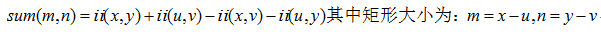

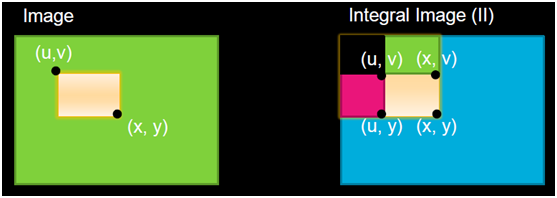


 在图像处理中有两个常用的相关算法，这就是积分图像(Integral Image)和积分直方图(Integral Histogram)，本文来讲解这两个算法的基本原理。
 
 在本文中主要以灰度图像来讲解。一个图像内矩形区域的积分是指这个矩形区域内所有灰度值的和，如图所示：
 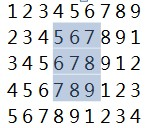

所选定区域的积分为：
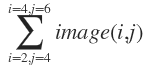

如图以3x6图像为例，左侧是原始图像，右侧是其积分图像，其中(2,4)位置的积分为16：
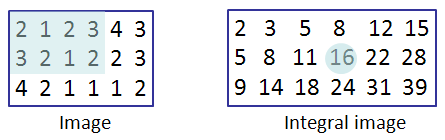

如果每个像素点都公式计算其积分，其运算量就太大了，为了减少计算量，专家经过推导给出了如下计算方法：如图所示：
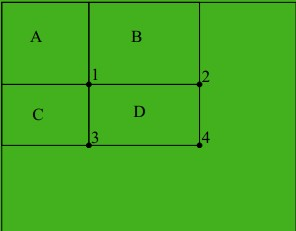

- 区域1 : = sum(A);
- 区域2 : = sum(A + B);
- 区域3 : = sum(A + C);
- 区域4 : = sum(A + B + C + D);

所以，如果需要计算D区域中的灰度和，则

sum(D) = 区域4 - 区域2 - 区域3 + 区域1 （都是灰度值）。

很明显，这里仅仅只需要通过查表得到 1、2、3、4点的积分图像的值即可得到。由此计算任意点积分方法可以化为：



其中integral(i,j)表示(i,j)点积分值，而image(i,j)表示的是该点图像灰度值，由此可以知道计算一个图像积分的运算量与这个图像的大小差不多。
  下面再说，积分直方图(Integral Histogram)。一个图像内矩形区域的积分积分直方图是指这个矩形区域内所有灰度值的频数。普通的灰度直方图是指一个图像各灰度级出现的频数，如图所示：
    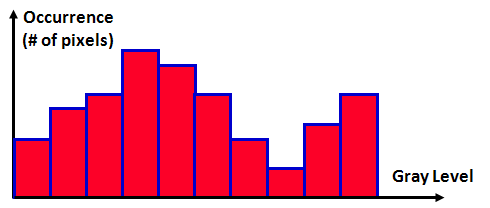

而积分直方图如图所示：
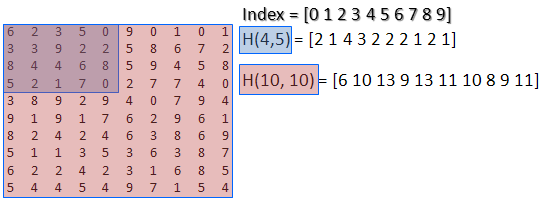

本图是一个灰度级为[0,9]的图像，H(4,5)表示的是(0,0)到(4,5)所有像素所有灰度级出现的频数，即后面的数字[2 1 4 3 2 2 2 1 2 1]表示灰度级[0 1 2 3 4 5 6 7 8 9]在区域里出現的频数。如同积分图的计算方法，积分直方图也可以用类似的方法进行。
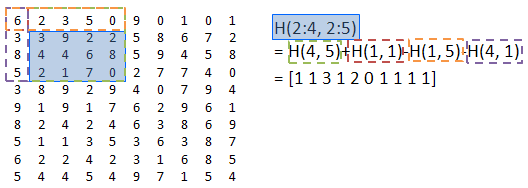

公式如下：
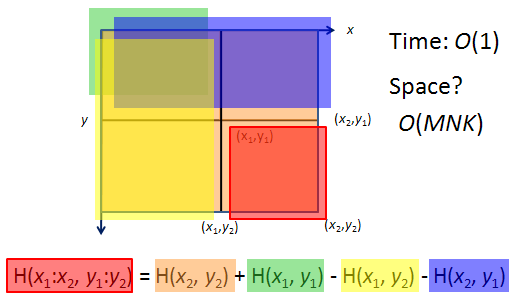

也就是可以如下进行：
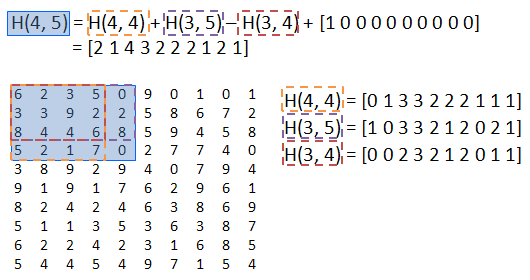

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import skimage.io
import imageio

In [20]:
src = imageio.imread('../datas/f3.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [5]:
def sum_region(top_left, bottom_right, integral_image):
    #Getting co-ordinates
    tlx, tly = top_left[0], top_left[1]
    brx, bry = bottom_right[0], bottom_right[1]
    #Getting values of the edge points
    A = integral_image[tlx][tly]
    B = integral_image[tlx][bry]
    C = integral_image[brx][tly]
    D = integral_image[brx][bry]
    #Calculating sum
    S = D - B - C + A
    return S

def to_integral_image_gray(img):
    #Getting the shape of img
    m, n = img.shape
    integral_image = np.zeros((m+1, n+1))
    for i in range(1, m+1):
        integral_image[i][1] = img[i-1][0] +  integral_image[i-1][1]
    for j in range(1, n+1):
        integral_image[1][j] = img[0][j-1] +  integral_image[1][j-1] 
    for i in range(2, m+1):
        for j in range(2, n+1):
            integral_image[i][j] = (img[i-1][j-1] +  integral_image[i-1][j] +  integral_image[i][j-1] - integral_image[i-1][j-1])
    return  integral_image


In [12]:
dr = to_integral_image_gray(src[:,:,0])
dg = to_integral_image_gray(src[:,:,1])
db = to_integral_image_gray(src[:,:,2])
dst = cv2.merge([dr,dg,db])
dst = np.clip(dst,0,255)
dst = np.uint8(dst)

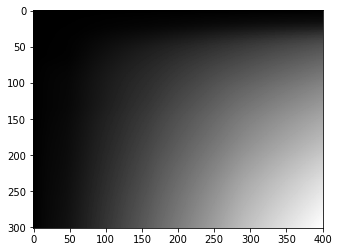

In [18]:
plt.imshow(dr,'gray')

In [19]:
def to_integral_image2(img_arr):
    row_sum = np.zeros(img_arr.shape)
    integral_image_arr = np.zeros((img_arr.shape[0]+1, img_arr.shape[1]+1))
    for y in range(img_arr.shape[1]):
        for x in range(img_arr.shape[0]):
            row_sum[x, y] = row_sum[x,y-1] + img_arr[x, y]
            integral_image_arr[x+1, y+1] = integral_image_arr[x, y+1] + row_sum[x, y]
    return integral_image_arr

def sum_region2(integral_image_arr, top_left, bottom_right):
    if top_left == bottom_right:
        return integral_image_arr[top_left]
    top_right = (top_left[0], bottom_right[1])
    bottom_left = (bottom_right[0], top_left[1])
    return integral_image_arr[bottom_right] - integral_image_arr[top_right] - integral_image_arr[bottom_left] + integral_image_arr[top_left]

In [21]:
dst = to_integral_image2(gray)

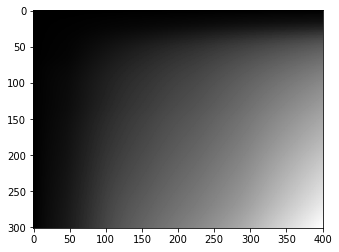

In [22]:
plt.imshow(dst,'gray')

In [23]:
ii = sum_region2(dst,0,0)

In [27]:
# 直接调用OpenCV函数

integral = cv2.integral(gray)

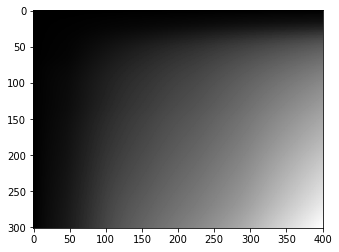

In [28]:
plt.imshow(integral,'gray')

参考：

[1]. http://blog.sina.com.cn/s/blog_5562b0440102wgxs.html

[2]. https://blog.csdn.net/jia20003/article/details/52710751